# 27Al CQ prediction with SOAP features

In [1]:
import json
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from pymatgen.core.structure import Structure as ST
from src.soap_utilities import getXY, get_species
import copy
from scipy import sparse

### preprocessing and generate soap feature
------------------------------------------------------------

In [2]:
#only show warnings once
import warnings
warnings.simplefilter('once')

In [3]:
# Read processed data and continue
with open("./data/processed_data_0.5.json", "r") as file:
    data_reload = json.load(file)
for data in data_reload:
    data['structure'] = ST.from_dict(data['structure'])
print("length of data set is:", len(data_reload))

length of data set is: 1681


In [6]:
# Atom Species
species_list, compositions = get_species(data_reload)
print("num of species in the data set:",len(species_list))

num of species in the data set: 76


In [4]:
X,y,loc = getXY(data_reload,species)
print(X.shape,y.shape)

100%|██████████| 1681/1681 [13:04<00:00,  2.14it/s]

(8081, 4163280) (8081, 3)


In [11]:
#Cache X and y
sparse.save_npz("./data/soap_X.npz", X)
y[['nmr']].to_csv("./data/soap_y.csv")


### PCA of X
----------------------------------------------

In [2]:
# reload X
X = sparse.load_npz("./data/soap_X.npz")

In [ ]:
from sklearn.decomposition import TruncatedSVD

N = 35
pca = TruncatedSVD(n_components=N,n_iter=8,random_state=20)
X_pca_fit = pca.fit(X)
X_pca = X_pca_fit.transform(X)

print(f"PCA covers {sum(X_pca_fit.explained_variance_ratio_)}% of variance")
print (f'PCA done! New shape {X_pca.shape}')

In [ ]:
# cache X_pca
np.savetxt('./data/soap_X_pca.csv',data,delimiter=',')

### Train and test of random forest model
----------------------------------------------------

In [8]:
# Get X_pca and y
X_pca = np.loadtxt('./data/soap_X_pca.csv', delimiter=',')
y = pd.read_csv('./data/soap_y.csv')[['nmr']]

In [9]:
# Get absolute value of CQ
y['nmr'] = abs(y['nmr'])

# Train test split
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X_pca, y, test_size=0.2,random_state=20)

print(X_train.shape,y_train.shape,X_test.shape,y_test.shape)

(6464, 35) (6464, 1) (1617, 35) (1617, 1)


In [10]:
%%time
# Grid Search for Algorithm Tuning
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import uniform, randint
import math

# create and fit a kernel ridge regression model
model = RandomForestRegressor(random_state=10,min_samples_split=4,min_samples_leaf=2)

param = {"n_estimators": randint(low=100, high=500), 
         "max_depth": uniform(10, 200),
         "max_features": ['auto', 'sqrt','log2']
         }

grid = RandomizedSearchCV(
    estimator=model,
    param_distributions=param,
    n_iter=10,
    scoring=["neg_mean_absolute_error", "neg_mean_squared_error", "r2"],
    refit="r2",
    cv=5,
    n_jobs=8,
)

grid.fit(X_train, y_train['nmr'])

# summarize the results of the grid search
train_r2 = np.sort(grid.cv_results_['mean_test_r2'])[-1]
train_RMSE = math.sqrt(-np.sort(grid.cv_results_['mean_test_neg_mean_squared_error'])[-1])
train_MAE = -np.sort(grid.cv_results_['mean_test_neg_mean_absolute_error'])[-1]

print('training score: R2 = {}, RMSE = {}, MAE = {}'.format(train_r2, train_RMSE, train_MAE))
print(grid.best_estimator_)

training score: R2 = 0.8796040295741754, RMSE = 1.4078039251850811, MAE = 0.6256690725165839
RandomForestRegressor(max_depth=178.2539710108405, min_samples_leaf=2,
                      min_samples_split=4, n_estimators=357, random_state=10)
CPU times: user 49 s, sys: 137 ms, total: 49.1 s
Wall time: 3min 42s


test scores: R2 = 0.9296297919370002, RMSE = 1.0319225298441448, MAE = 0.4407572591128868
date and time: 01-04-2022_17-15-59


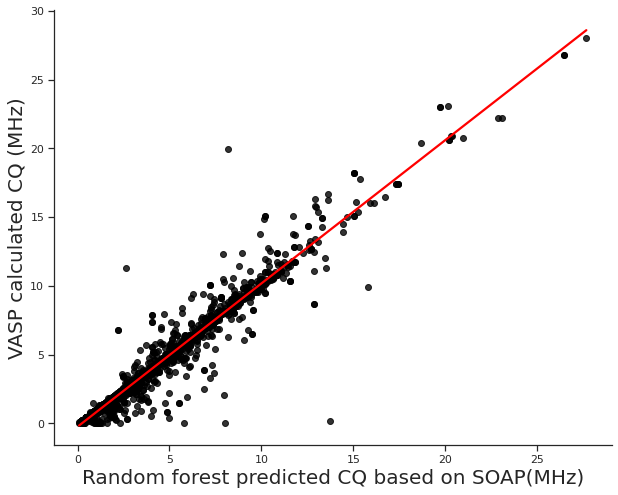

CPU times: user 1.25 s, sys: 567 ms, total: 1.82 s
Wall time: 505 ms


In [11]:
%%time
# Predict test set
from sklearn.metrics import r2_score, mean_squared_error, mean_absolute_error
import seaborn as sns
import matplotlib.pyplot as plt
from datetime import datetime
sns.set()

y_rf = grid.predict(X_test)

test_r2 = r2_score(y_test['nmr'], y_rf)
test_RMSE = math.sqrt(mean_squared_error(y_test['nmr'], y_rf))
test_MAE = mean_absolute_error(y_test['nmr'], y_rf)

print("test scores: R2 = {}, RMSE = {}, MAE = {}".format(test_r2, test_RMSE, test_MAE))


# write down the date for png save
predict_result = {}
predict_result["VASP_CQ"] = y_test['nmr']
predict_result["RF_predicted_CQ"] = y_rf
predict_result = pd.DataFrame(predict_result)

# datetime object containing current date and time
now = datetime.now() 
# dd/mm/YY H:M:S
dt_string = now.strftime("%d-%m-%Y_%H-%M-%S")
print("date and time:",dt_string)

#plot the correlation
sns.set_style("ticks")
fig, ax = plt.subplots(figsize = (10,8))
plot = sns.regplot(
    x="RF_predicted_CQ",
    y="VASP_CQ",
    data=predict_result,
    ci=None,
    scatter_kws={"color": "black"}, 
    line_kws={"color": "red"}
)
ax.set_xlabel("Random forest predicted CQ based on SOAP(MHz)",fontsize=20)
ax.set_ylabel("VASP calculated CQ (MHz)",fontsize=20)
sns.despine()
plt.show()

# Export y_rf and y_test as .csv
y_output = copy.deepcopy(y_test)
y_output['CQ_rf'] = y_rf
y_output = pd.DataFrame(y_output)
y_output.to_csv('./data/SOAP_test.csv')

### Build learn curve base on sample size

In [13]:
# reload X_pca and y
X_pca = pd.read_csv('./data/soap_X_pca.csv',header=None)
y = pd.read_csv('./data/soap_y.csv')[['nmr']]
y['nmr'] = abs(y['nmr'])
y.rename(columns={'nmr':'CQ'},inplace=True)

In [18]:
# get a series of smaller data sets (10%-100%)
whole_dataset = pd.concat([y,X_pca],axis=1)

small_sets = []
for p in range(1,11):
    small_sets.append(whole_dataset.sample(frac=p/10,random_state=20))

In [19]:
# Build learning curve
from src.Utility import learning_curve_samplesize

model = RandomForestRegressor(random_state=10,
                            min_samples_split=4,
                            min_samples_leaf=2,
                            max_depth=50,
                            n_estimators=500,
                            max_features='sqrt')
feature_names = list(range(35))
learning_curve_dict = learning_curve_samplesize(model, small_sets,feature_names)
pd.DataFrame(learning_curve_dict)

100%|██████████| 10/10 [04:49<00:00, 28.99s/it]


,sample_size,cv_r2_mean,cv_RMSE_mean,cv_MAE_mean,train_r2,train_RMSE,train_MAE,test_r2,test_RMSE,test_MAE
0,808,0.342153,3.058649,2.131431,0.855399,1.447943,0.942720,0.443359,2.960077,2.014010
1,1616,0.571233,2.474864,1.607740,0.909895,1.143875,0.695029,0.619480,2.587366,1.664302
2,2424,0.659992,2.263507,1.399868,0.926374,1.056215,0.596218,0.735919,2.010198,1.203893
3,3232,0.687566,2.138621,1.240843,0.936741,0.965506,0.516347,0.768757,2.010749,1.045331
4,4040,0.755628,1.928248,1.073244,0.948993,0.883959,0.436734,0.800165,1.769526,0.967890
5,4849,0.759273,1.917765,0.976852,0.954103,0.840285,0.397353,0.822997,1.691377,0.870142
6,5657,0.808165,1.695042,0.866991,0.959120,0.786032,0.356968,0.862838,1.551921,0.741074
7,6465,0.833592,1.619753,0.793186,0.963331,0.762004,0.330141,0.923565,1.146387,0.596246
8,7273,0.855938,1.493400,0.711519,0.970575,0.677139,0.283249,0.869155,1.544309,0.638357
9,8081,0.869229,1.443319,0.670102,0.974760,0.637264,0.261669,0.919042,1.167617,0.522703


In [ ]:
# save the result
pd.DataFrame(learning_curve_dict).to_csv('./data/soap_learning_curve_samplesize.csv')